In [ ]:
#downlaoddata

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests


IMG_SIZE = 128
SAMPLES_PER_CLASS = 6000
BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
IMG_ROOT = "/content/quickdraw_images"
DOWNLOAD_DIR = "/content/quickdraw_npy"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(IMG_ROOT, exist_ok=True)


class_names = [
    'flower', 'bat', 'lightning', 'umbrella', 'dumbbell', 'flip flops', 'bush', 'nail', 'bridge', 'bread',
    'leg', 'tree', 'cow', 'telephone', 'cup', 'bicycle', 'light bulb', 'crown', 'mouth', 'motorbike',
    'tooth', 'school bus', 'cactus', 'spoon', 'camel', 'helicopter', 'river', 'bird', 'butterfly', 'backpack',
    'table', 'hot air balloon', 'camera', 'hat', 'candle', 'bucket', 'beard', 'banana', 'eye', 'sock',
    'book', 'pillow', 'foot', 'flashlight', 'crab', 'fish', 'pencil', 'leaf', 'apple', 'donut'
]

#Download the data
for class_name in tqdm(class_names, desc="Downloading and processing"):
    clean_name = class_name.replace(" ", "_")
    file_path = os.path.join(DOWNLOAD_DIR, clean_name + ".npy")


    if not os.path.exists(file_path):
        url = BASE_URL + class_name.replace(' ', '%20') + ".npy"
        r = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(r.content)

    #Convert to images and save it as .png
    class_dir = os.path.join(IMG_ROOT, clean_name)
    os.makedirs(class_dir, exist_ok=True)
    data = np.load(file_path)[:SAMPLES_PER_CLASS]

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))


In [ ]:
#Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
#data augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    IMG_ROOT,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 255000 images belonging to 50 classes.
Found 45000 images belonging to 50 classes.


In [ ]:
#Buildng  MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)
learning_rate = 0.001

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


<ipython-input-3-0b2a375f7425>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,598,770 (9.91 MB)

 Trainable params: 340,786 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#Fine-tune the last (20) layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,598,770 (9.91 MB)

 Trainable params: 1,546,866 (5.90 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
#staart Model training
checkpoint = ModelCheckpoint("MobileNetV2_best.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
lrschedule = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, earlystop, lrschedule]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7020 - loss: 1.1647

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1415s 351ms/step - accuracy: 0.7021 - loss: 1.1646 - val_accuracy: 0.7604 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 2/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8241 - loss: 0.6720

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1302s 327ms/step - accuracy: 0.8241 - loss: 0.6720 - val_accuracy: 0.8246 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 3/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8436 - loss: 0.5903

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1274s 320ms/step - accuracy: 0.8436 - loss: 0.5903 - val_accuracy: 0.8435 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 4/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8540 - loss: 0.5475

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1279s 321ms/step - accuracy: 0.8540 - loss: 0.5475 - val_accuracy: 0.8553 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 5/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8632 - loss: 0.5103

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1292s 324ms/step - accuracy: 0.8632 - loss: 0.5103 - val_accuracy: 0.8591 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 6/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8659 - loss: 0.4947

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1291s 324ms/step - accuracy: 0.8659 - loss: 0.4947 - val_accuracy: 0.8630 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 7/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8730 - loss: 0.4683

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1269s 318ms/step - accuracy: 0.8730 - loss: 0.4683 - val_accuracy: 0.8670 - val_loss: 0.4965 - learning_rate: 0.0010
Epoch 8/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8765 - loss: 0.4530

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1272s 319ms/step - accuracy: 0.8765 - loss: 0.4530 - val_accuracy: 0.8717 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 9/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1279s 321ms/step - accuracy: 0.8804 - loss: 0.4366 - val_accuracy: 0.8709 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 10/10
3985/3985 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8818 - loss: 0.4293

3985/3985 ━━━━━━━━━━━━━━━━━━━━ 1291s 324ms/step - accuracy: 0.8818 - loss: 0.4293 - val_accuracy: 0.8722 - val_loss: 0.4840 - learning_rate: 0.0010


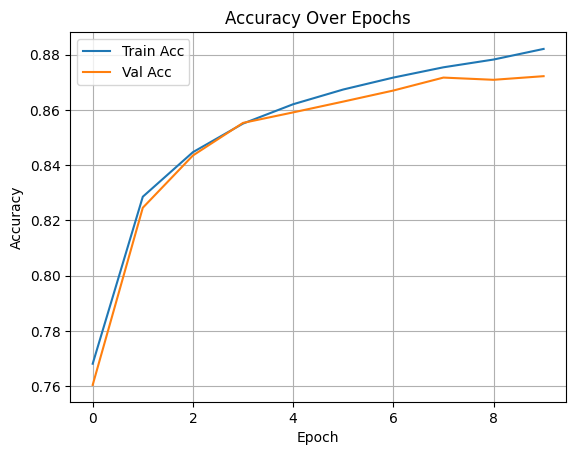

In [ ]:
import matplotlib.pyplot as plt
#ploting the performance
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(train_gen.class_indices)

{'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9, 'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18, 'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27, 'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35, 'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44, 'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49}


Below code for inferencing and calculating avg inference time


In [ ]:
#setuip for inference
import os
import numpy as np
from PIL import Image
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from time import perf_counter

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = 128
N_IMAGES = 5
MODEL_PATH = "/content/MobileNetv2_best.h5"
NPY_DIR = "/content/quickdraw_npy"
INFER_DIR = "/content/inference_images"

# Class mapping
class_indices = {
    'apple': 0, 'backpack': 1, 'banana': 2, 'bat': 3, 'beard': 4, 'bicycle': 5, 'bird': 6, 'book': 7, 'bread': 8, 'bridge': 9,
    'bucket': 10, 'bush': 11, 'butterfly': 12, 'cactus': 13, 'camel': 14, 'camera': 15, 'candle': 16, 'cow': 17, 'crab': 18,
    'crown': 19, 'cup': 20, 'donut': 21, 'dumbbell': 22, 'eye': 23, 'fish': 24, 'flashlight': 25, 'flip_flops': 26, 'flower': 27,
    'foot': 28, 'hat': 29, 'helicopter': 30, 'hot_air_balloon': 31, 'leaf': 32, 'leg': 33, 'light_bulb': 34, 'lightning': 35,
    'motorbike': 36, 'mouth': 37, 'nail': 38, 'pencil': 39, 'pillow': 40, 'river': 41, 'school_bus': 42, 'sock': 43, 'spoon': 44,
    'table': 45, 'telephone': 46, 'tooth': 47, 'tree': 48, 'umbrella': 49
}

class_names = [name.replace("_", " ") for name, _ in sorted(class_indices.items(), key=lambda x: x[1])]


In [ ]:

#Convert .npy to Images (.png)
selected_classes = random.sample(list(class_indices.keys()), 10)

os.makedirs(INFER_DIR, exist_ok=True)

for class_key in selected_classes:
    npy_path = os.path.join(NPY_DIR, class_key + ".npy")
    data = np.load(npy_path)[:N_IMAGES]
    class_dir = os.path.join(INFER_DIR, class_key)
    os.makedirs(class_dir, exist_ok=True)

    for i, img in enumerate(data):
        img = img.reshape(28, 28).astype(np.uint8)
        img = Image.fromarray(img).resize((IMG_SIZE, IMG_SIZE)).convert("RGB")
        img.save(os.path.join(class_dir, f"{i}.png"))

print(f"\nSaved {N_IMAGES} images each for: {[c.replace('_', ' ') for c in selected_classes]}")



Saved 5 images each for: ['motorbike', 'leaf', 'lightning', 'camera', 'pillow', 'apple', 'tree', 'dumbbell', 'donut', 'leg']


In [ ]:

#Load our Model 
model = load_model(MODEL_PATH)
print("Model loaded successfully.")


Model loaded successfully.


In [ ]:

#Prepre Data Generator

infer_datagen = ImageDataGenerator(rescale=1./255)

inference_gen = infer_datagen.flow_from_directory(
    INFER_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


Found 175 images belonging to 35 classes.


In [ ]:

#Inferee Time


@tf.function
def infer(x):
    return model(x)

_ = infer(inference_gen[0])

#Measure inference times (excluding first image)
inference_times = []

for i in range(1, len(inference_gen)):
    batch = inference_gen[i]
    start = perf_counter()
    _ = infer(batch)
    end = perf_counter()
    inference_times.append((end - start) * 1000)

avg_time = np.mean(inference_times)
print(f"\nPure Inference Time per Image (excluding warm-up): {avg_time:.2f} ms")



Pure Inference Time per Image (excluding warm-up): 16.53 ms


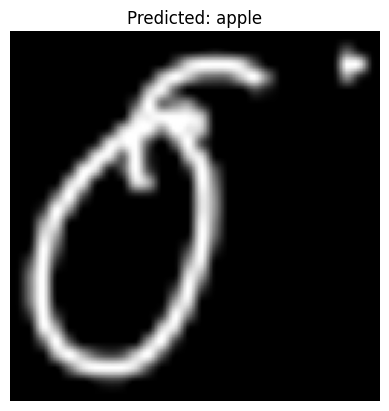

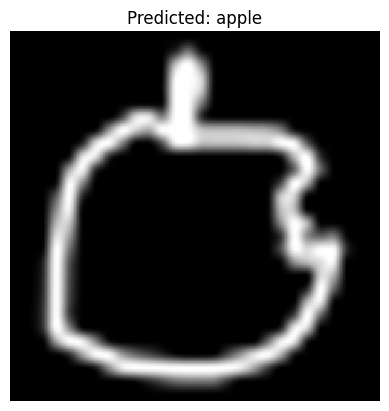

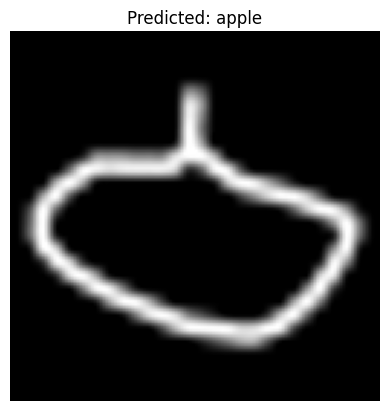

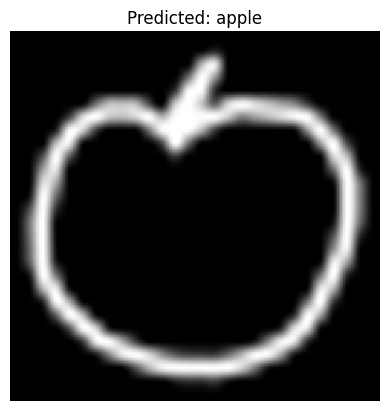

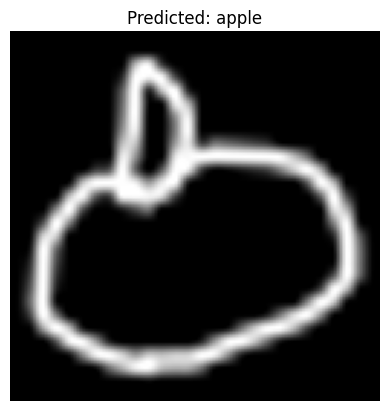

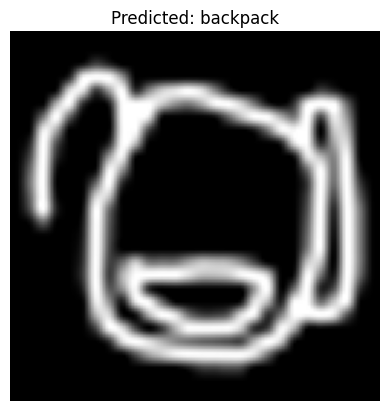

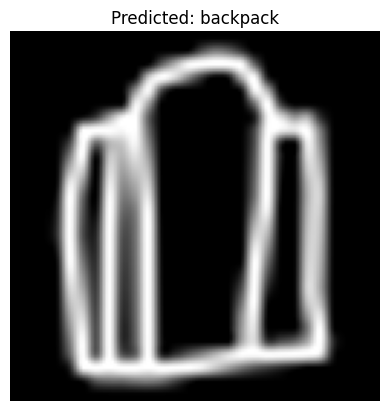

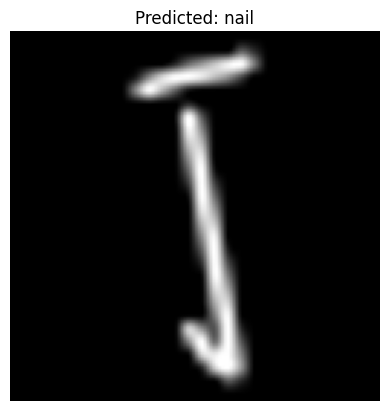

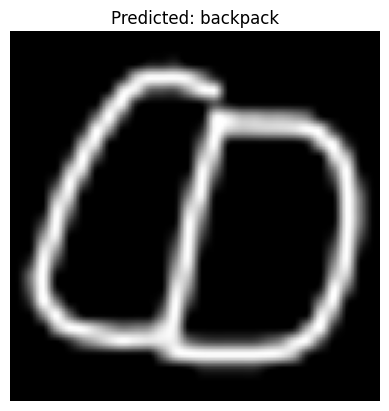

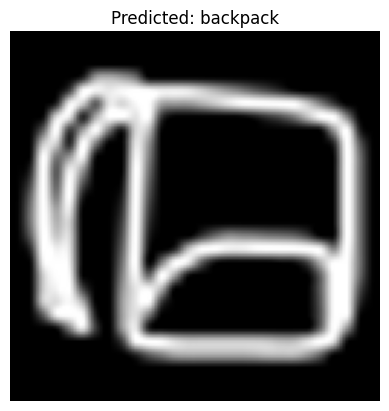

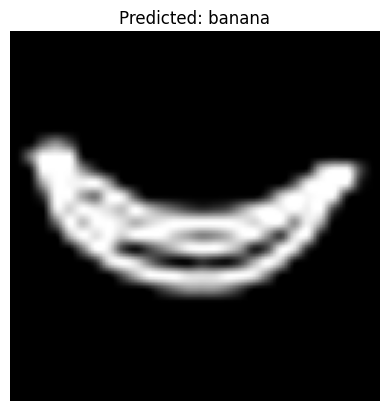

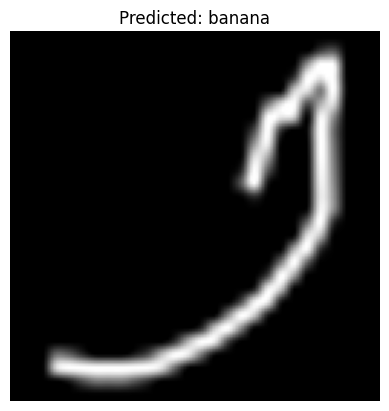

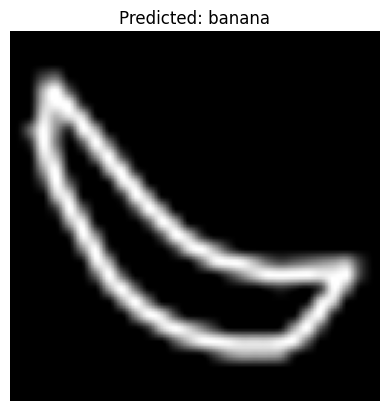

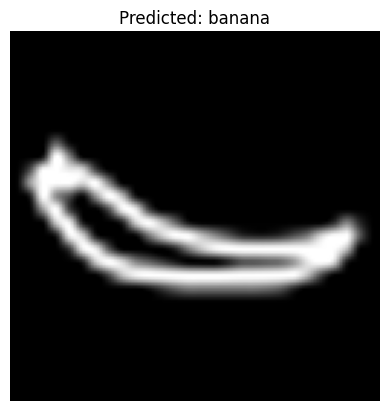

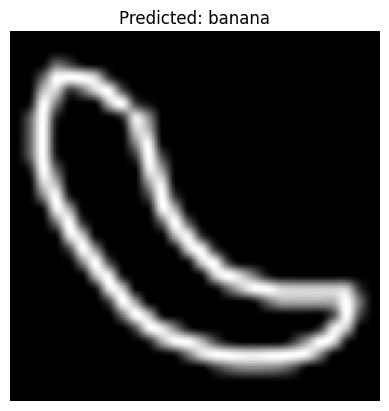

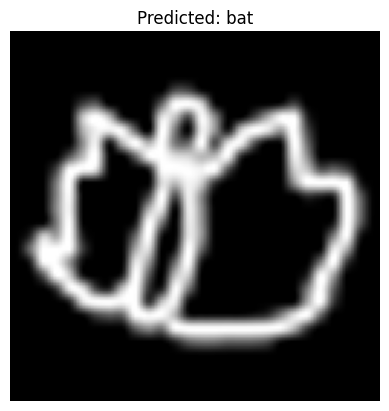

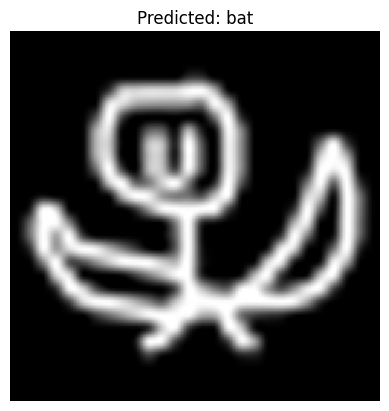

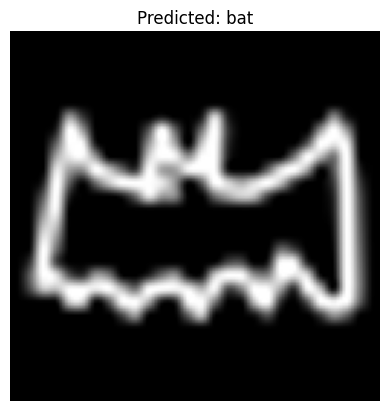

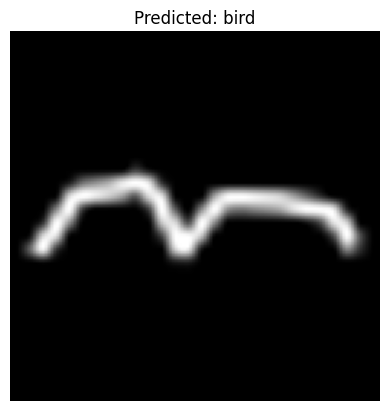

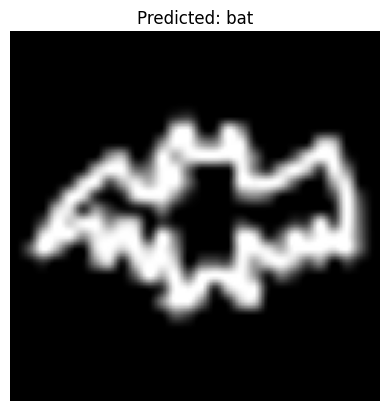

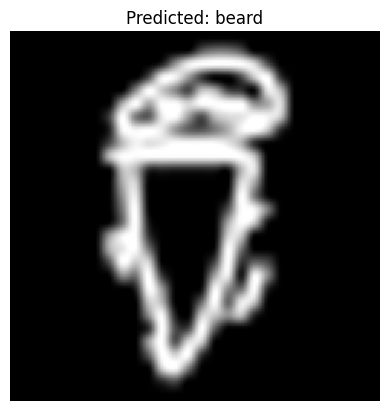

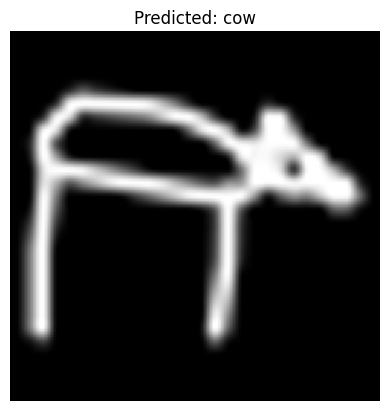

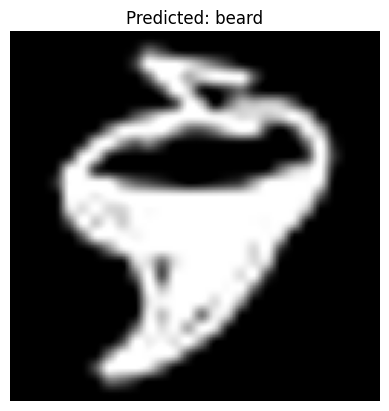

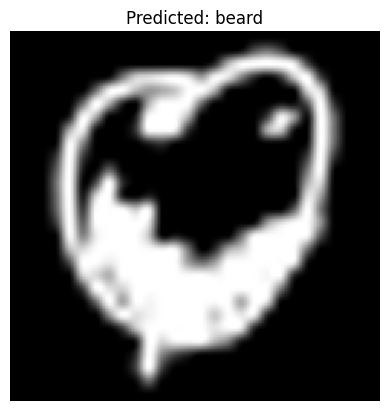

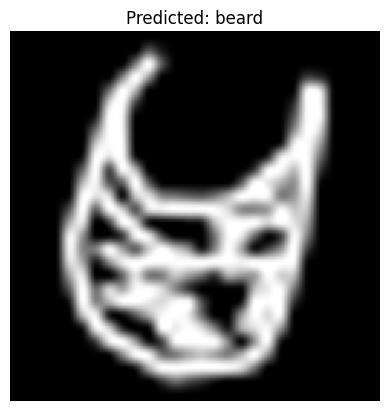

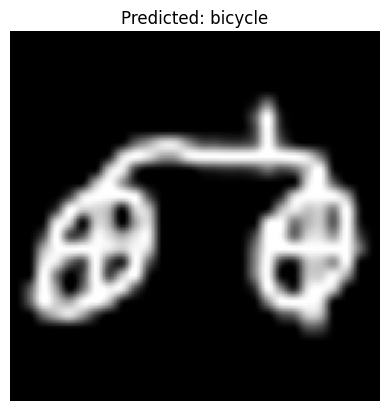

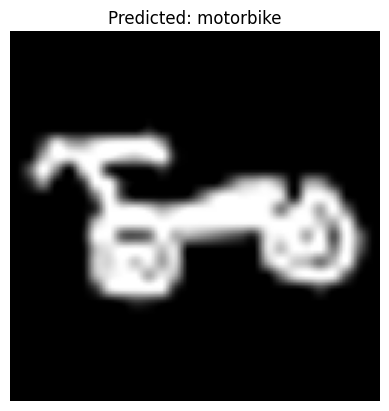

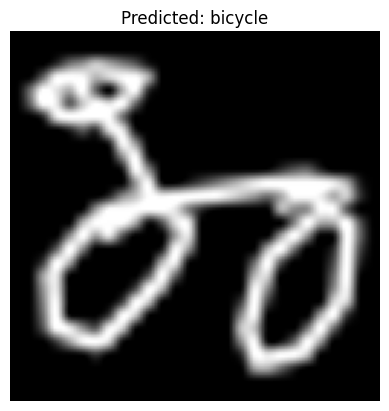

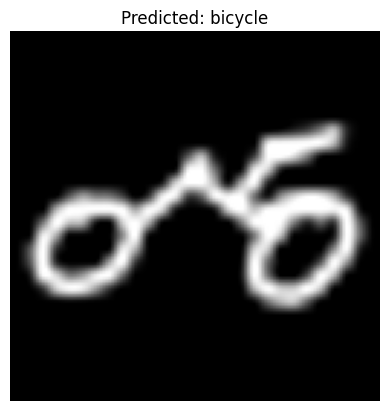

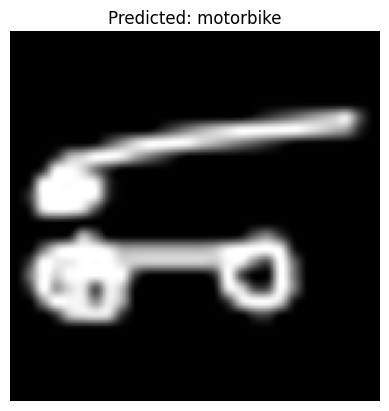

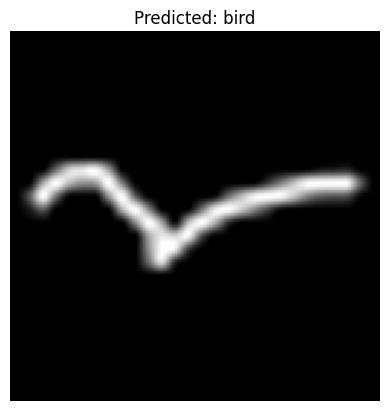

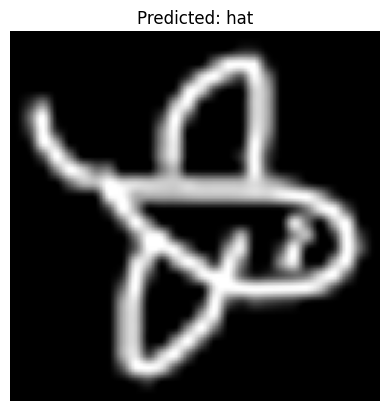

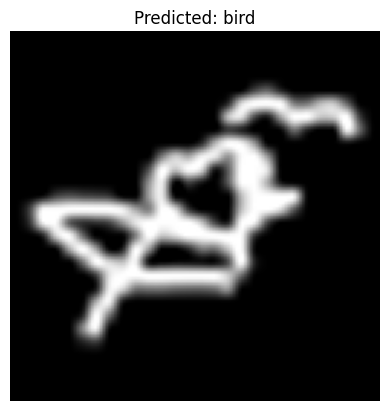

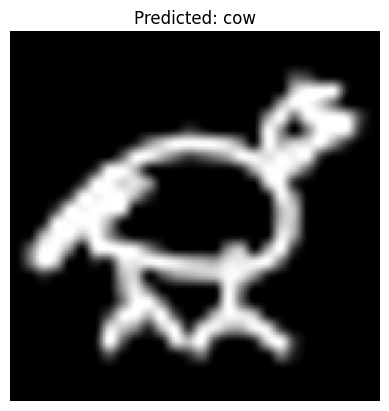

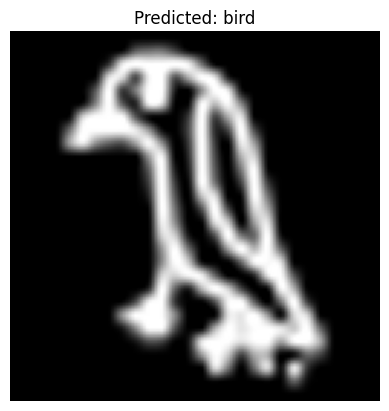

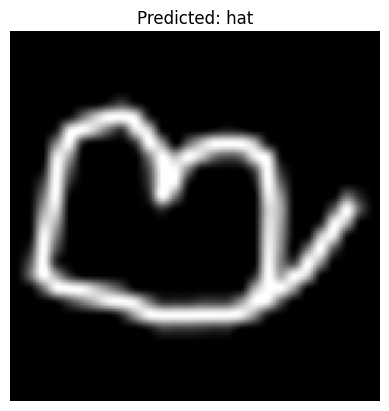

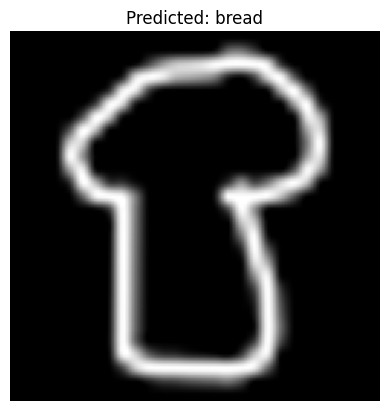

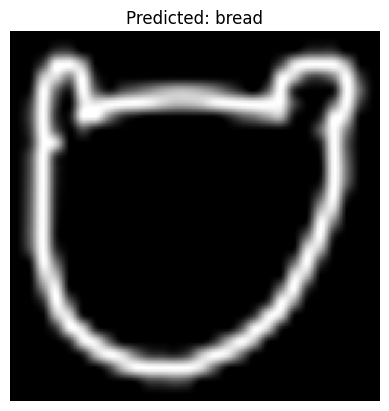

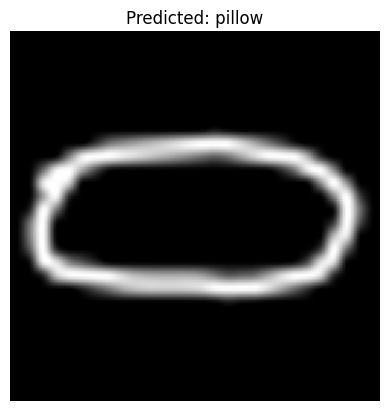

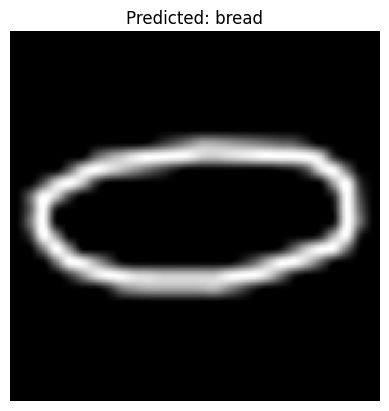

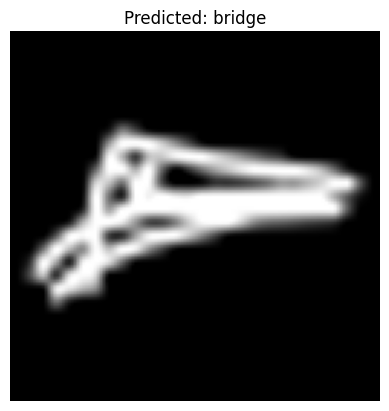

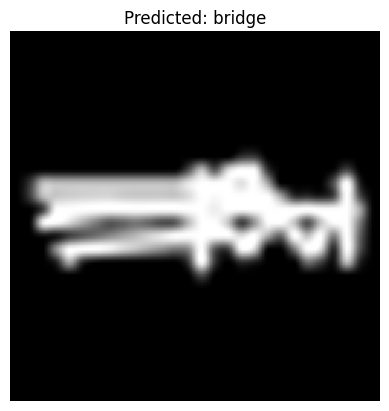

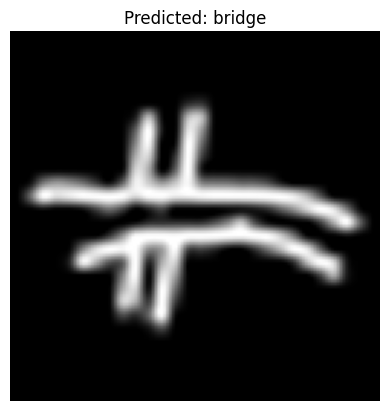

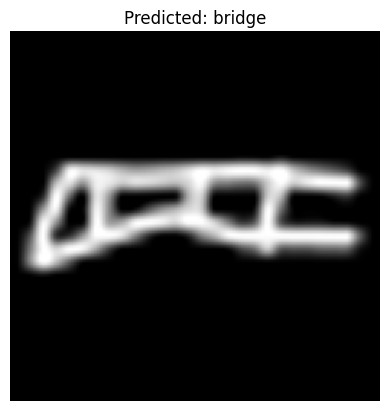

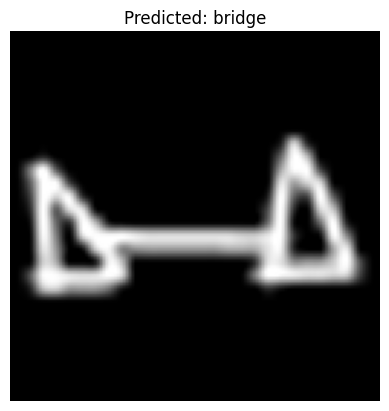

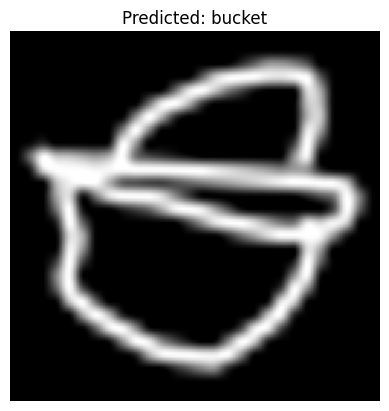

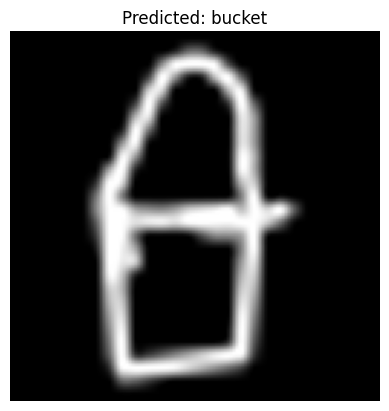

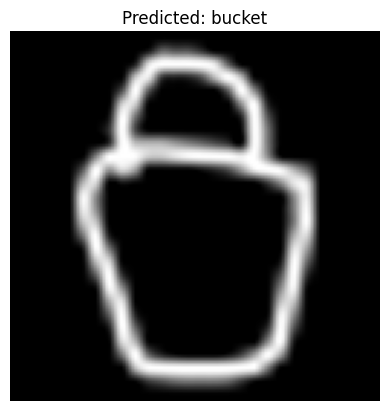

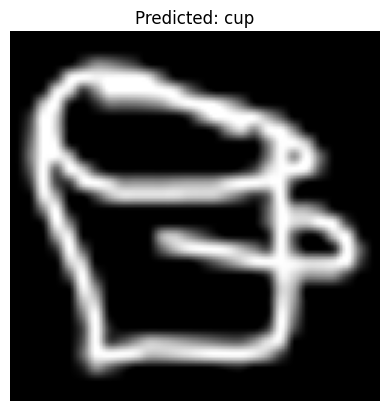

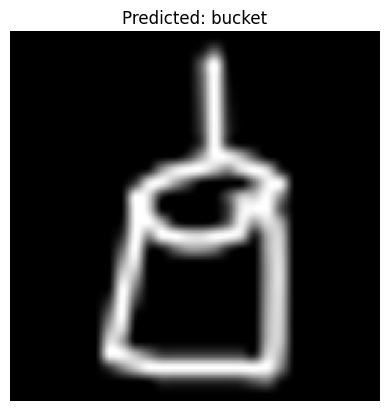

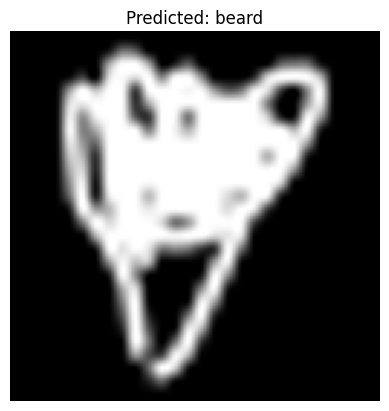

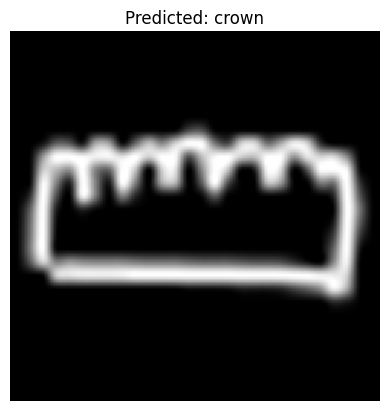

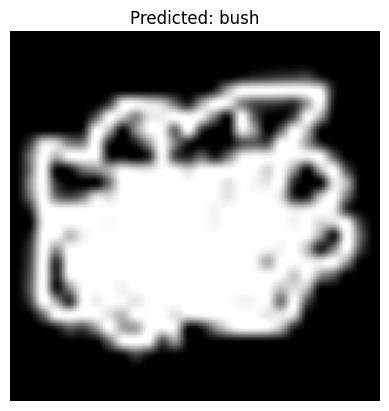

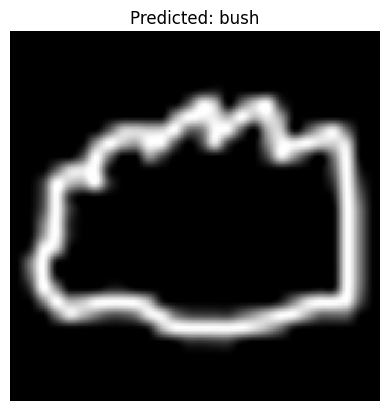

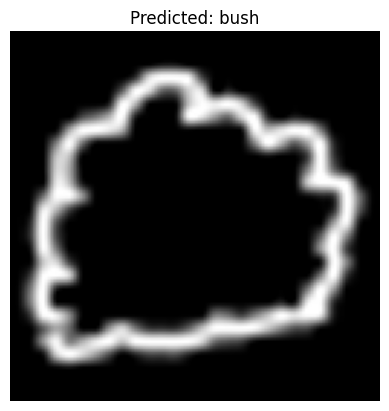

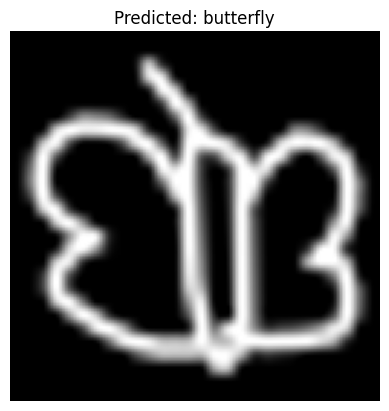

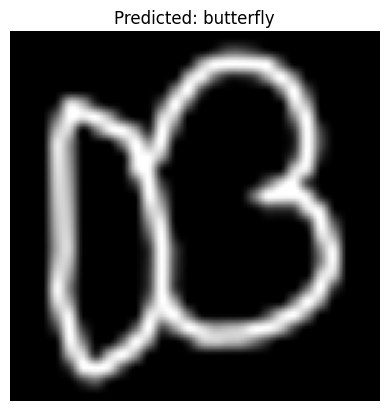

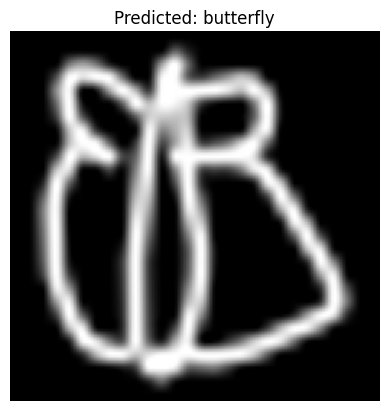

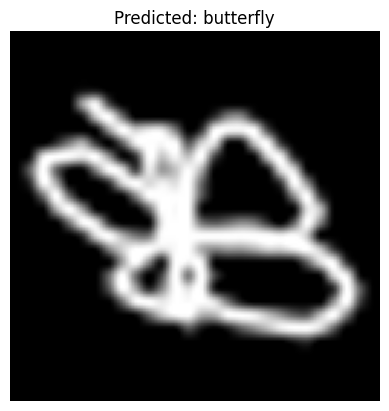

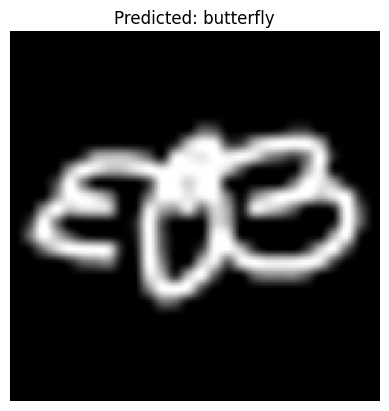

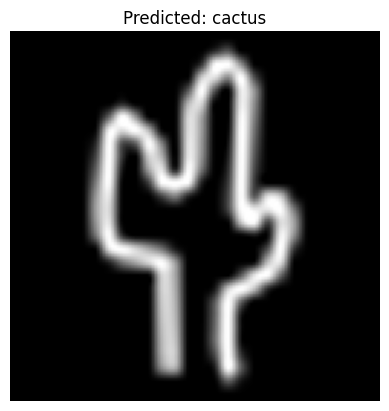

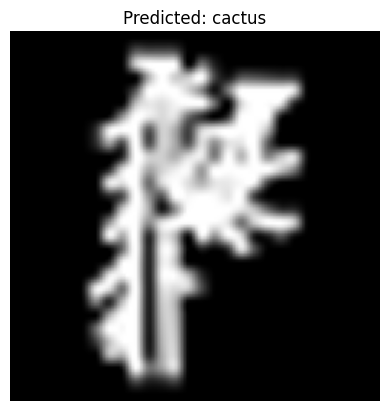

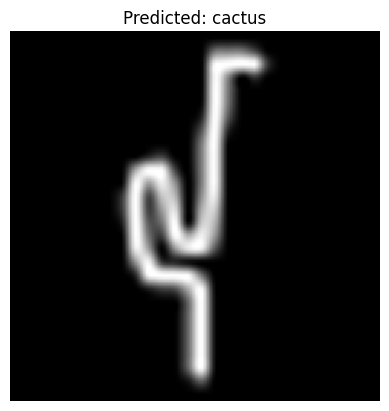

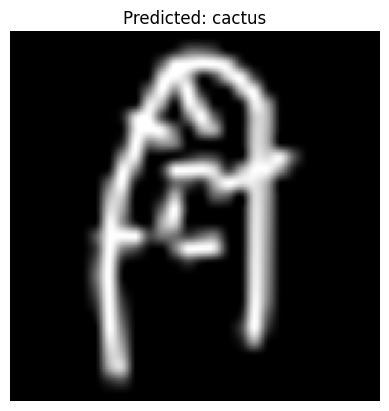

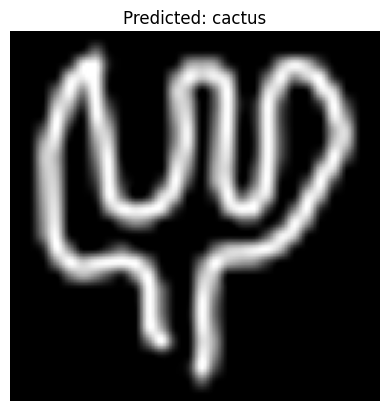

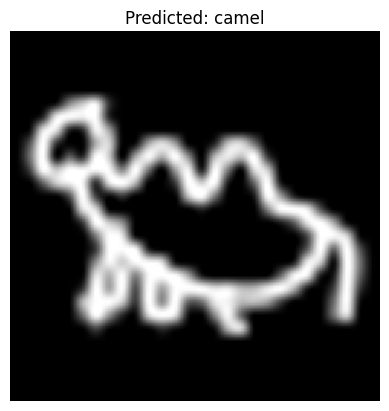

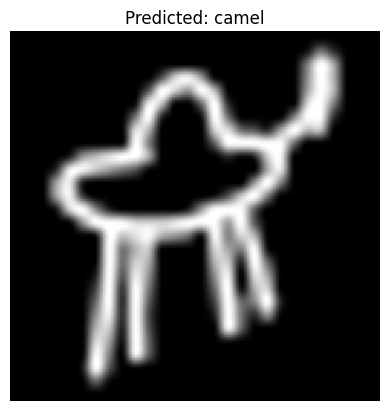

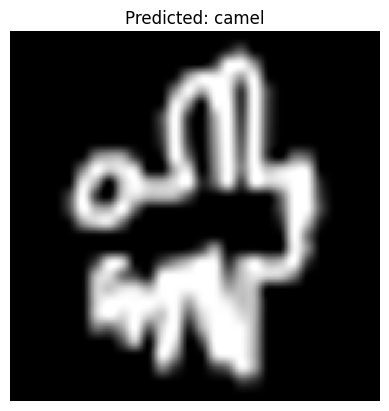

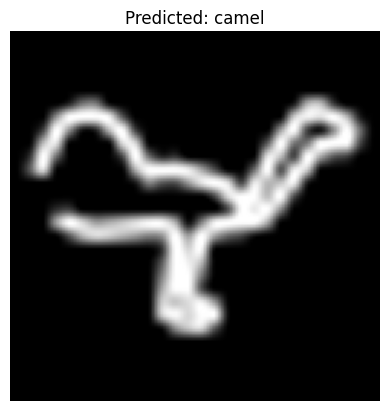

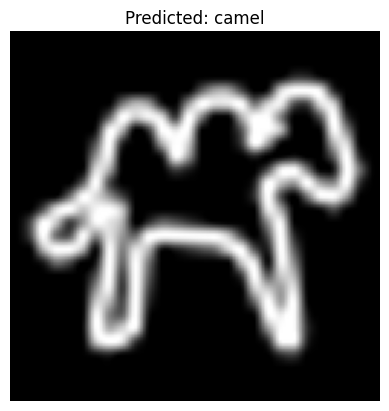

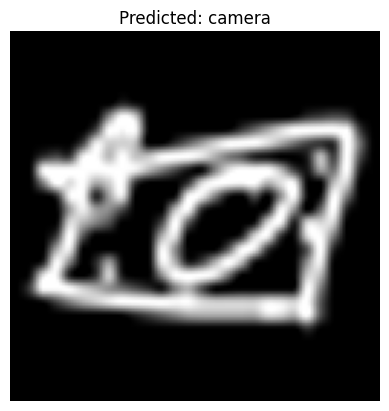

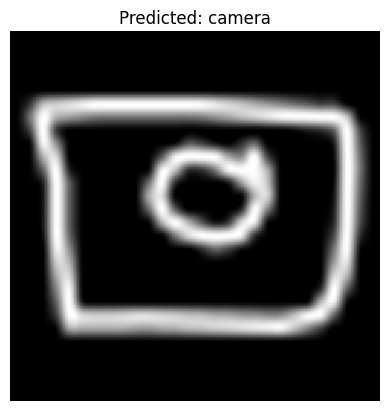

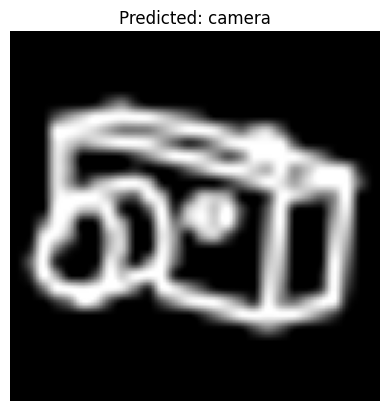

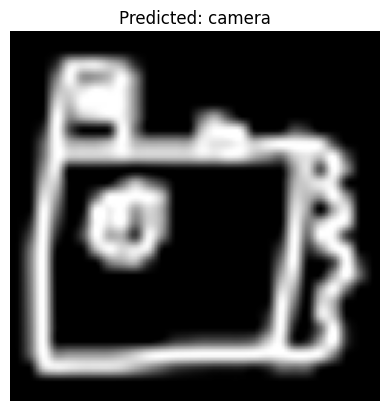

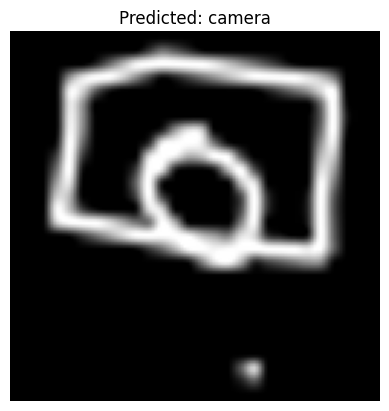

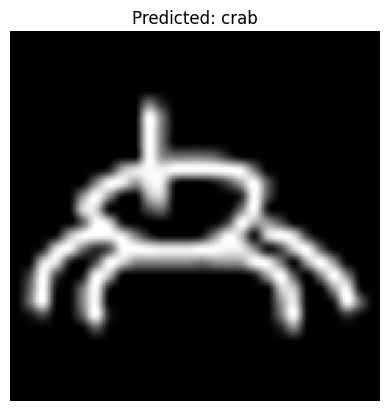

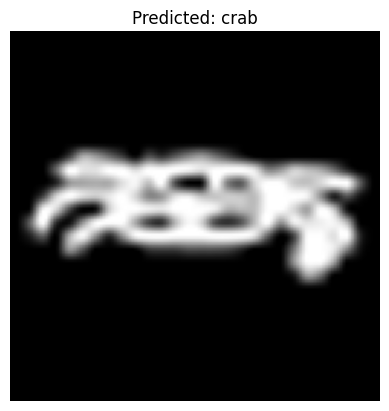

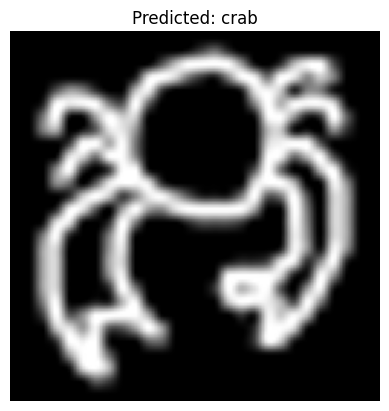

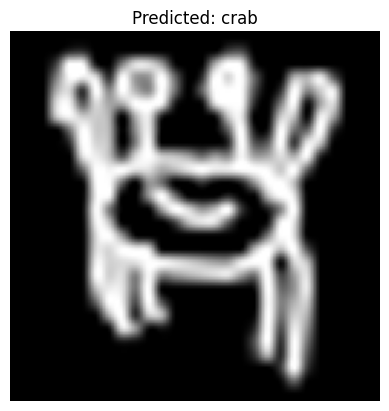

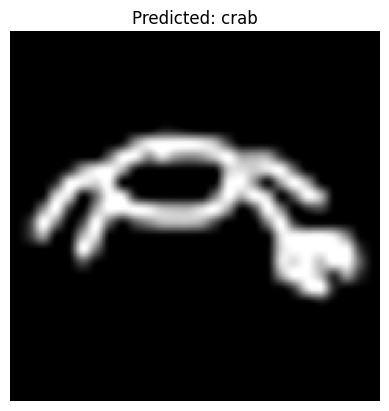

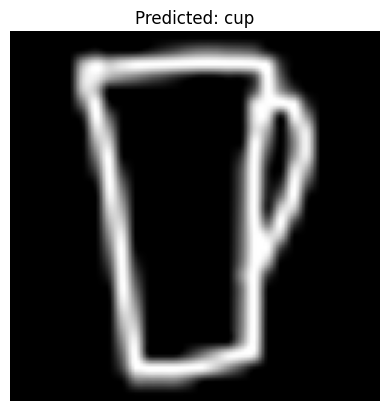

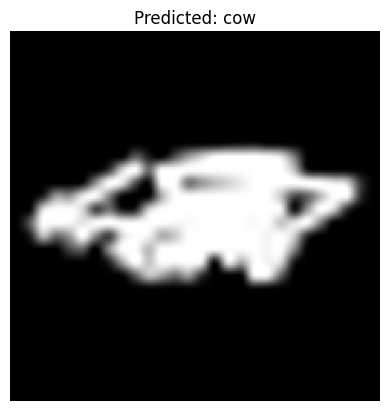

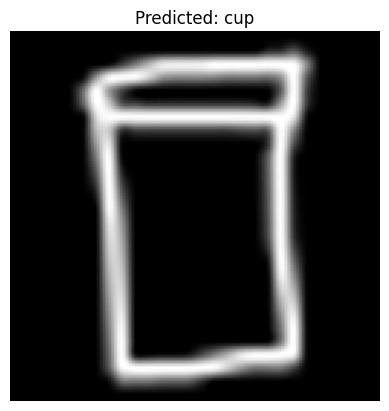

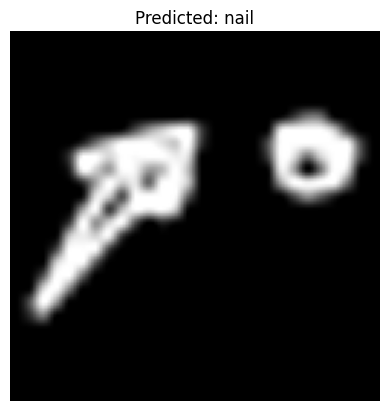

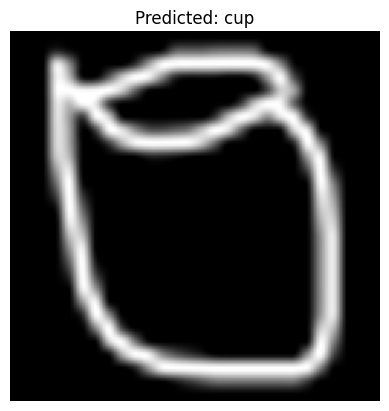

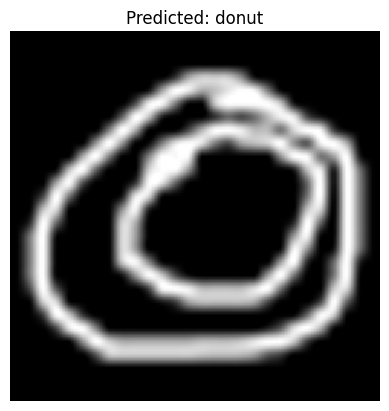

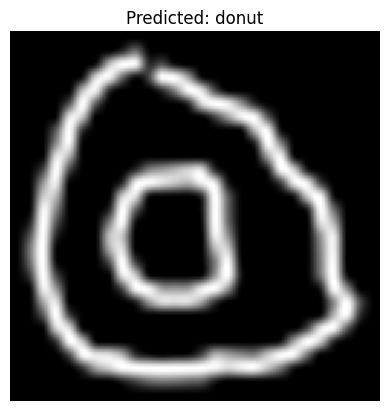

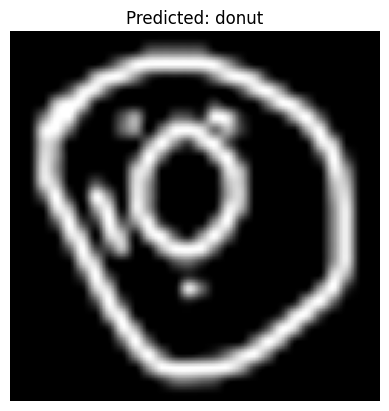

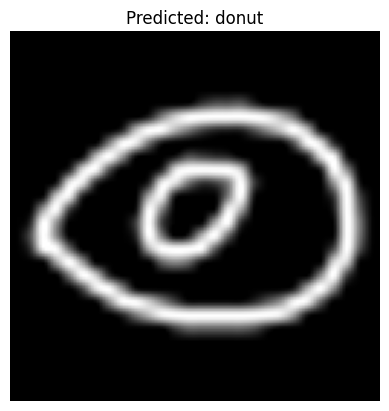

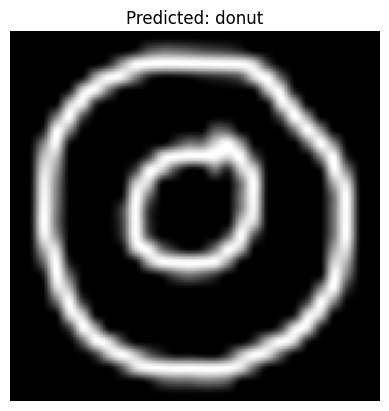

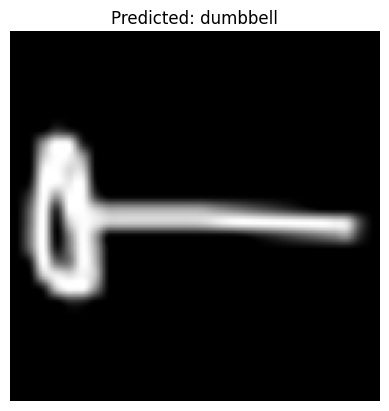

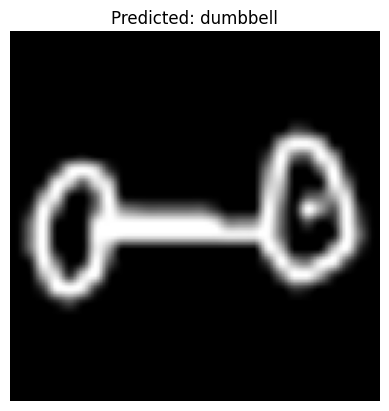

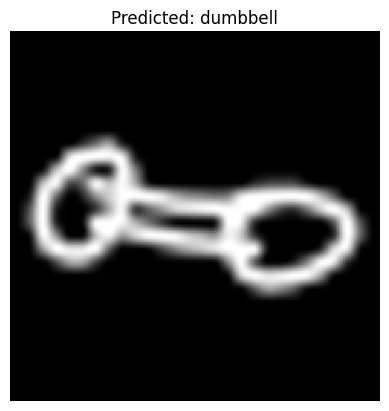

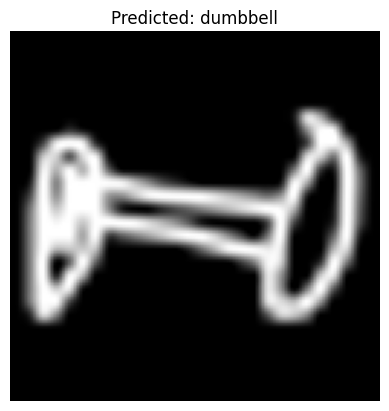

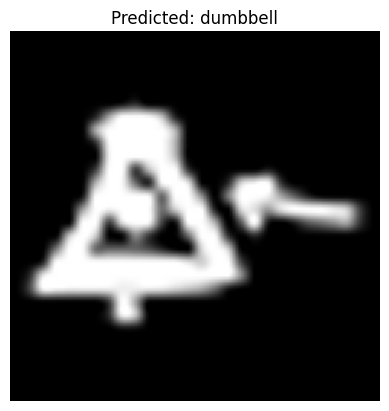

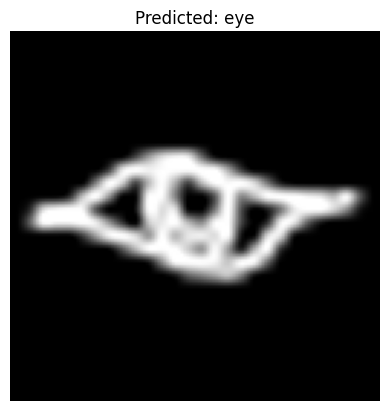

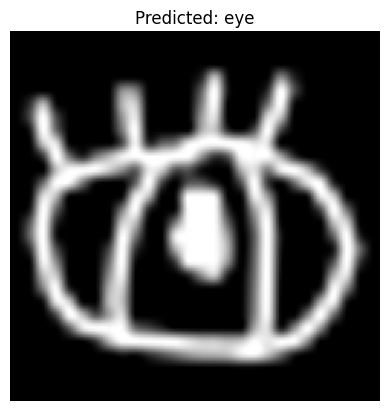

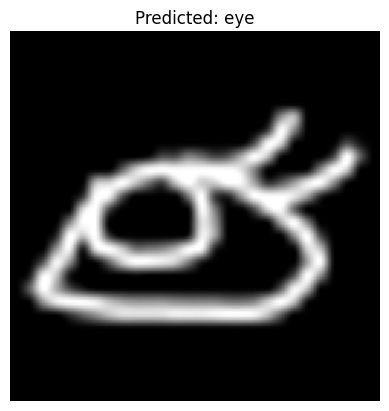

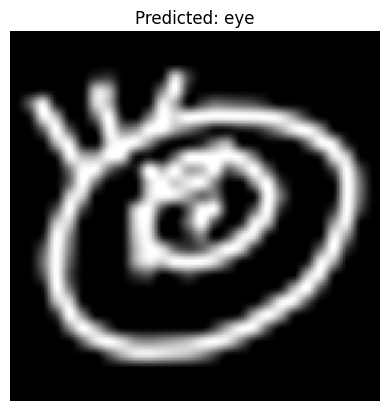

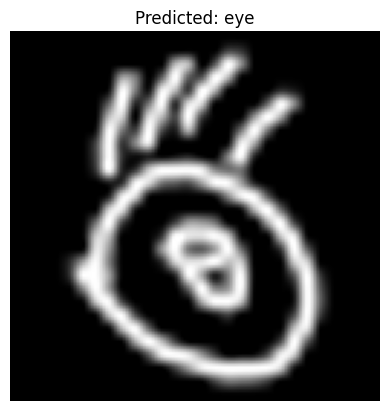

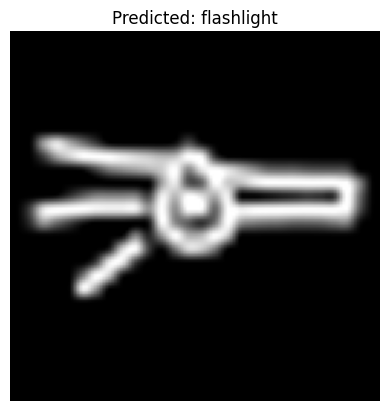

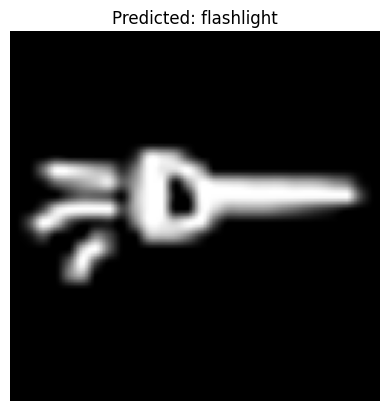

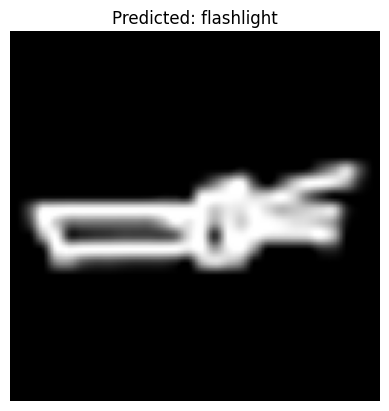

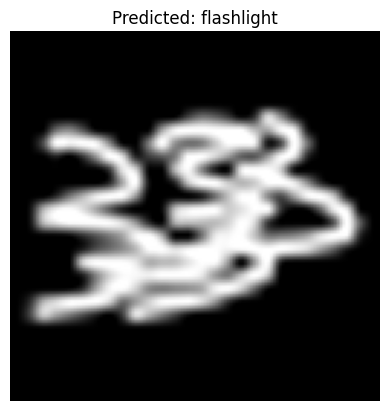

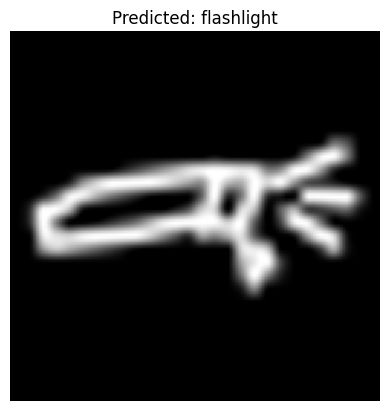

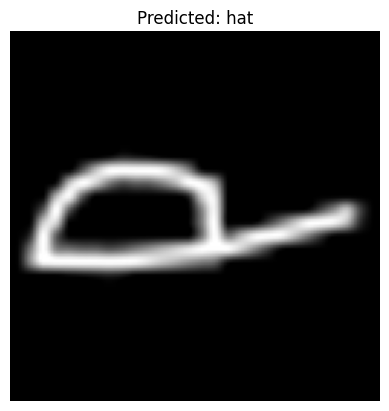

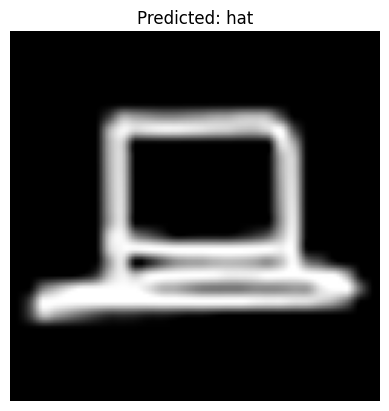

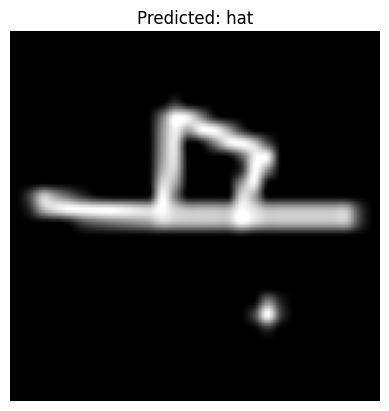

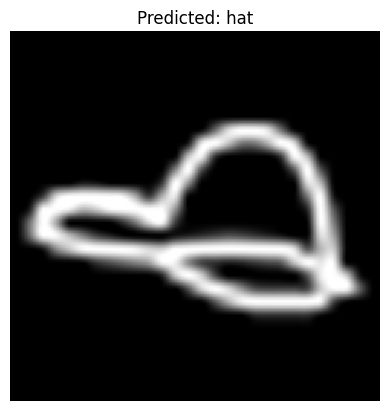

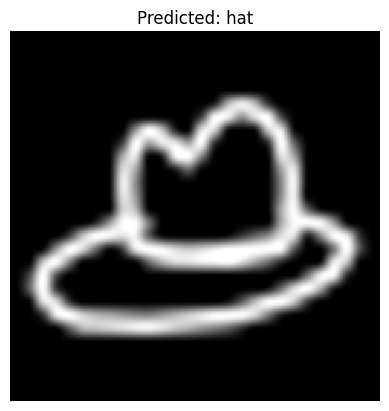

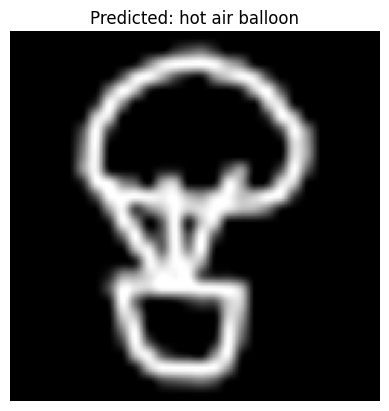

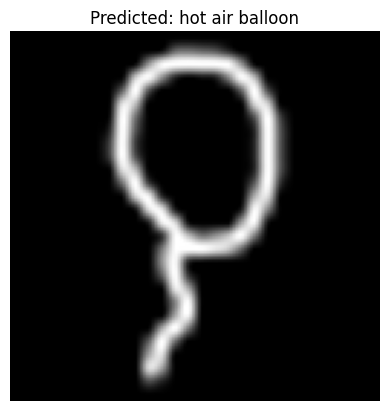

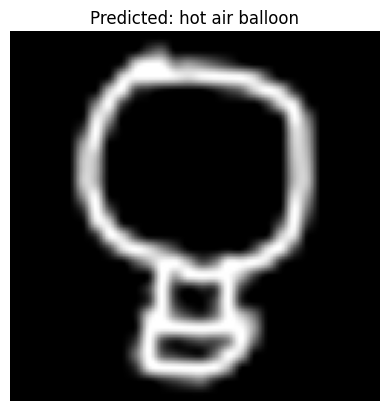

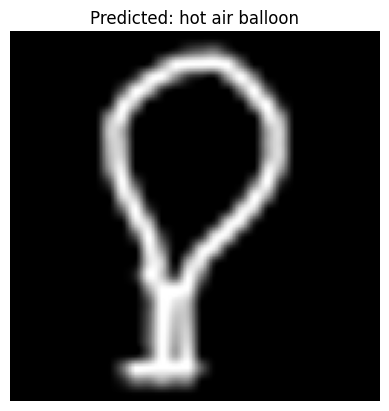

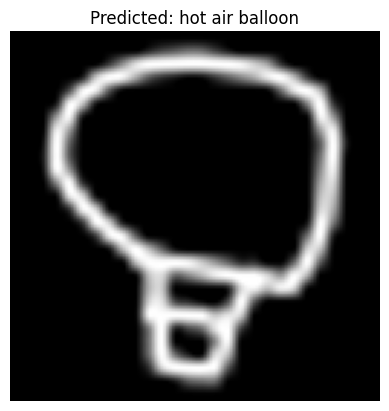

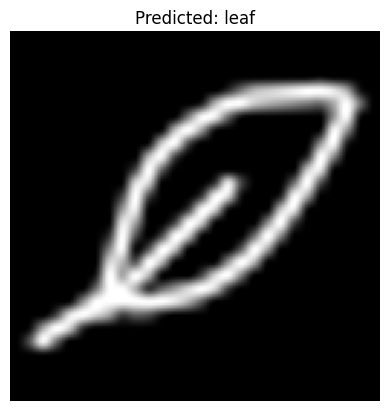

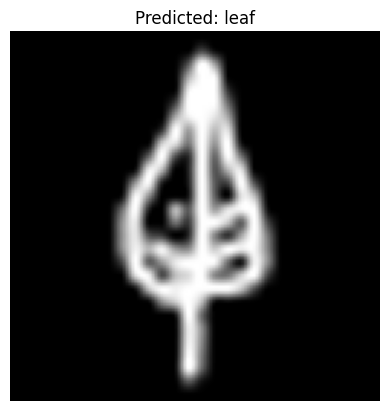

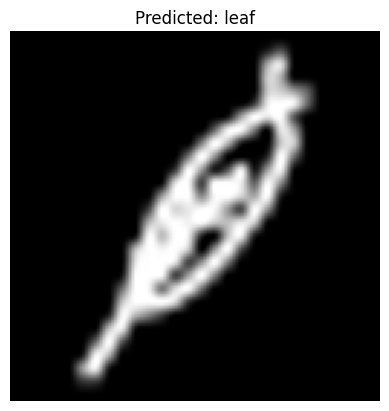

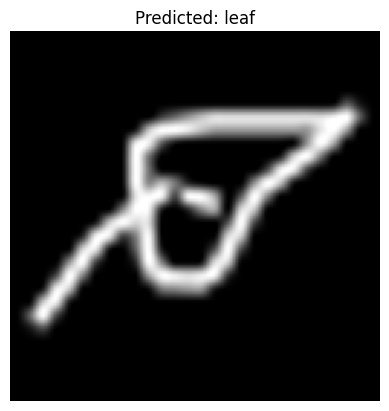

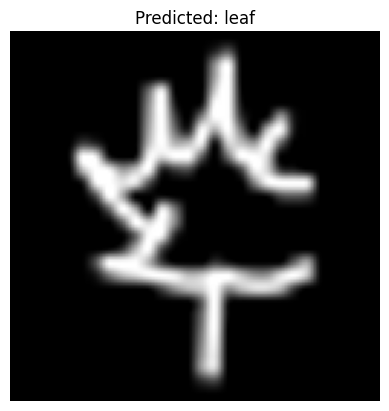

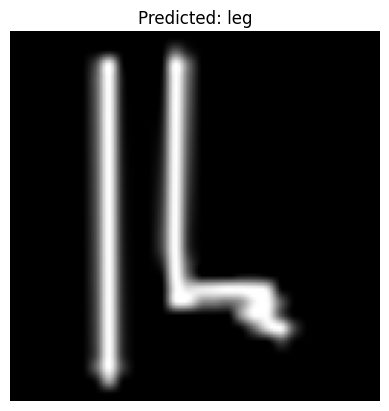

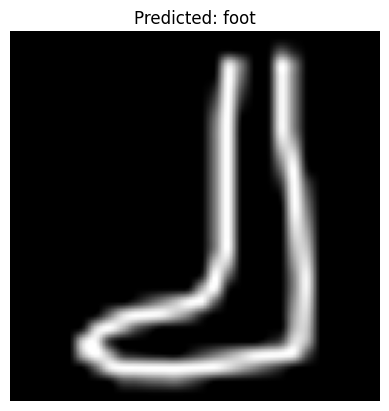

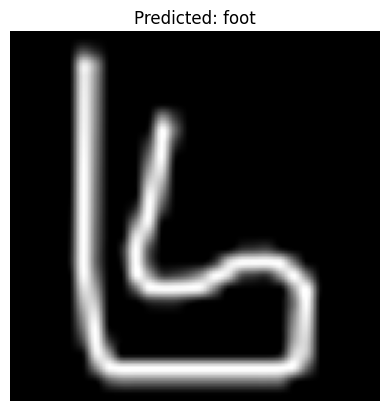

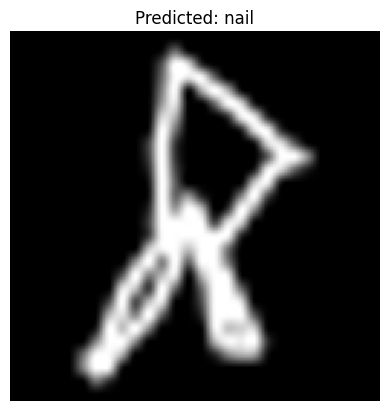

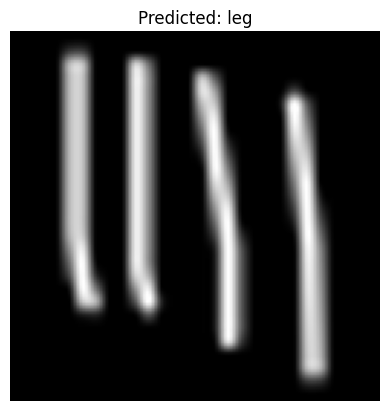

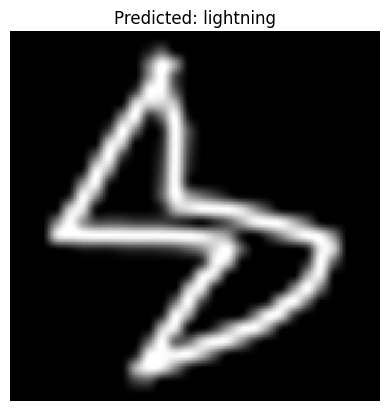

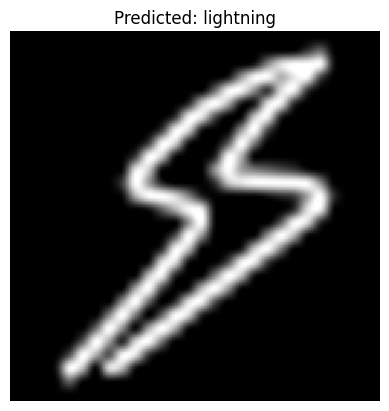

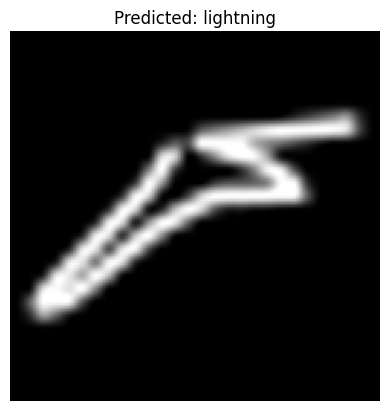

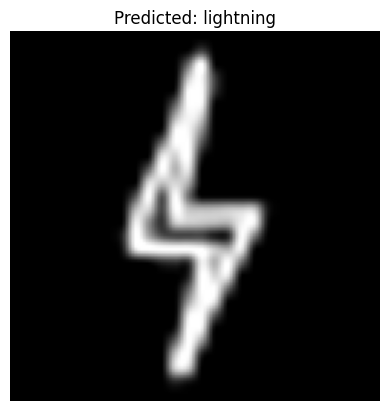

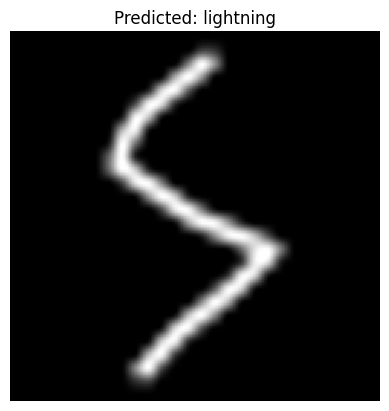

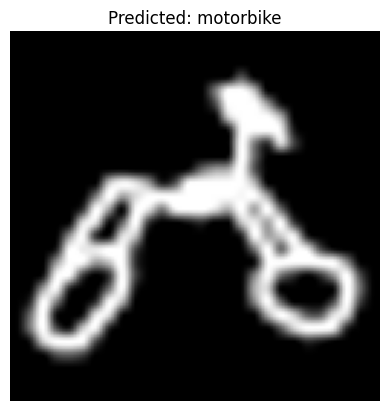

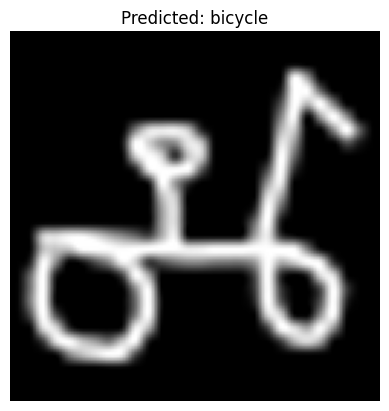

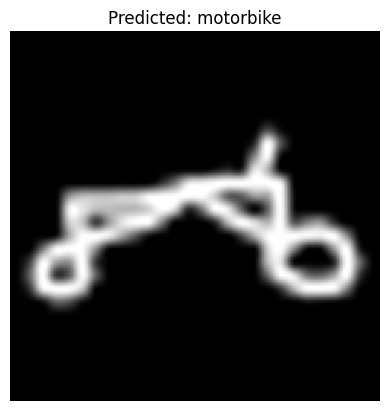

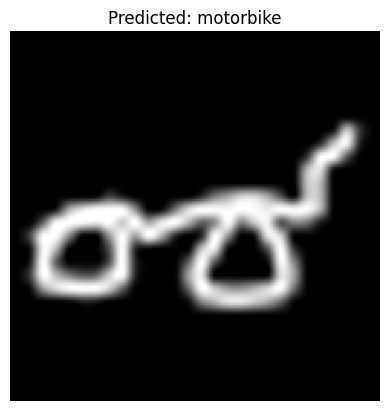

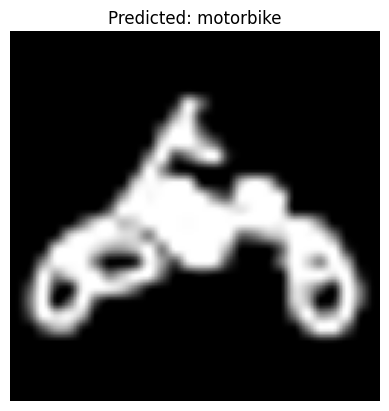

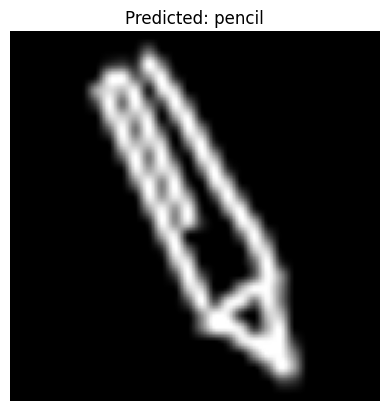

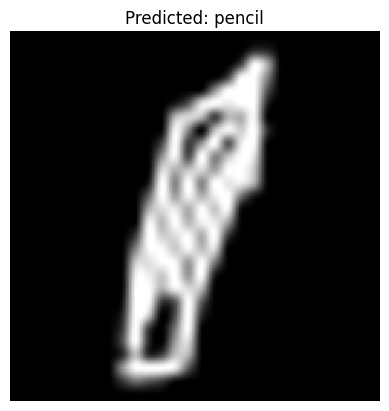

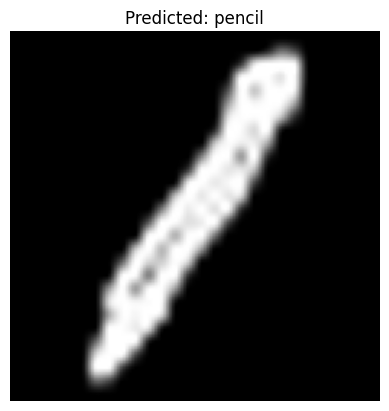

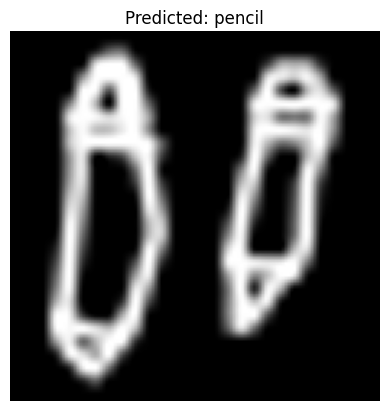

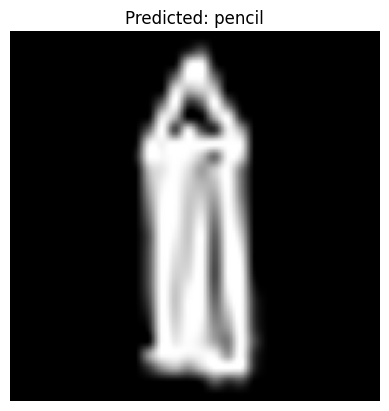

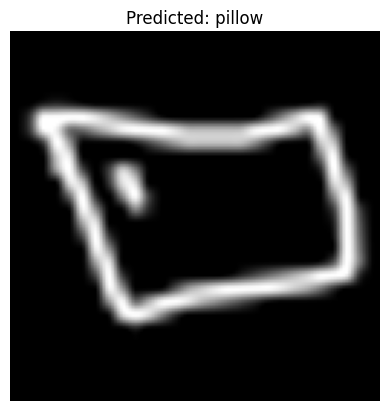

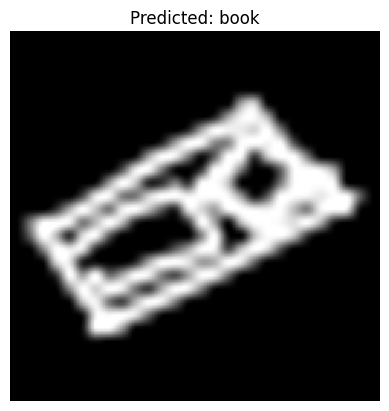

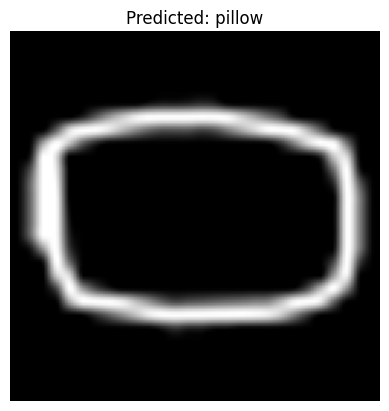

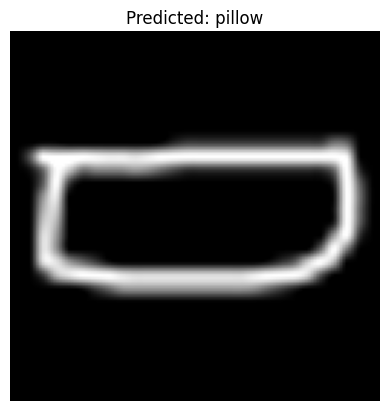

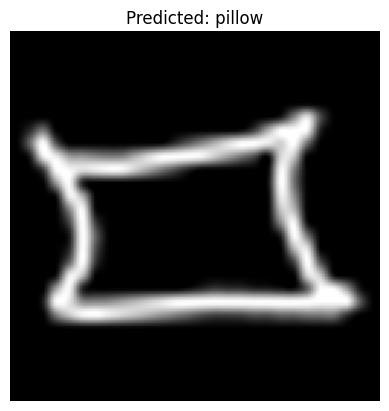

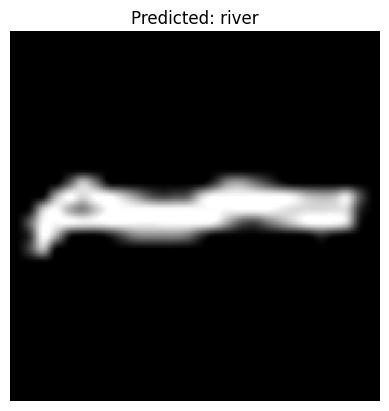

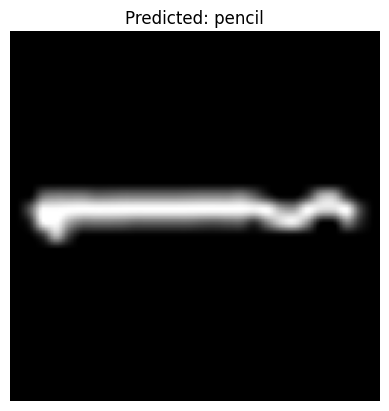

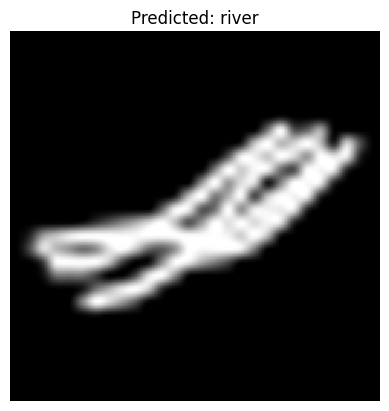

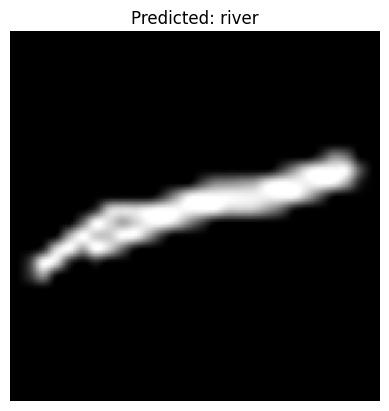

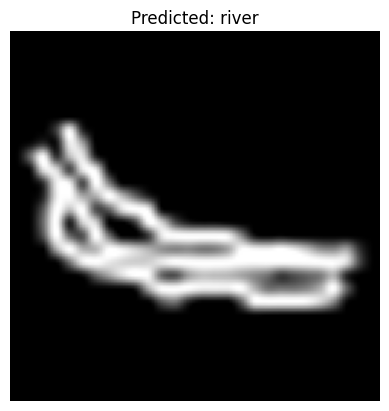

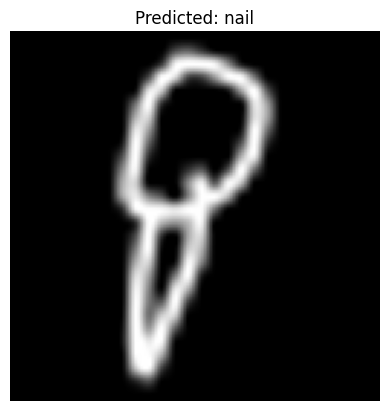

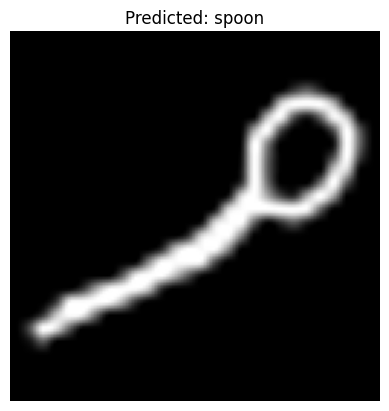

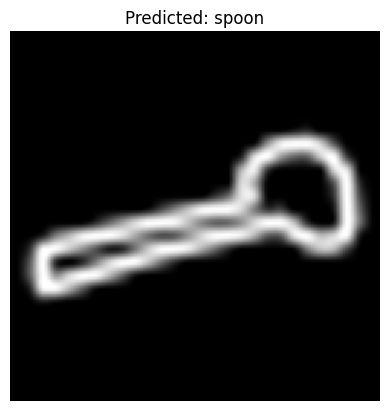

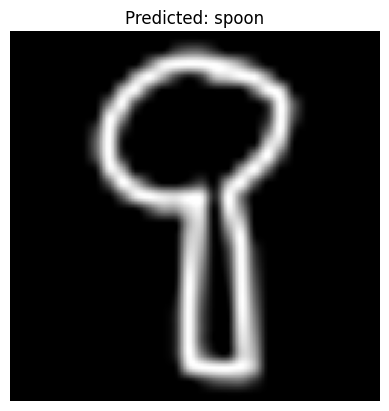

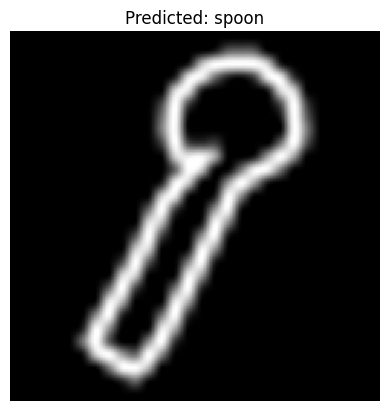

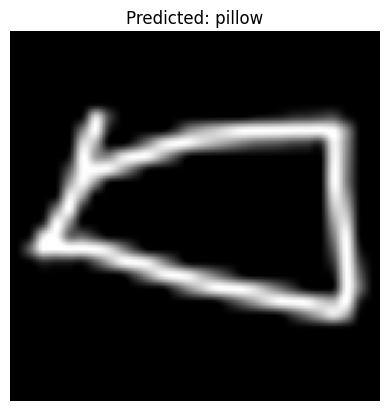

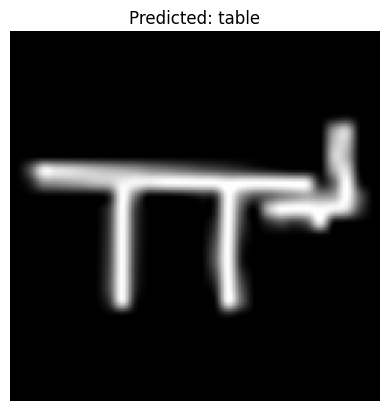

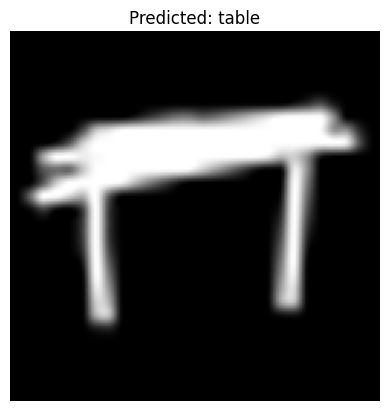

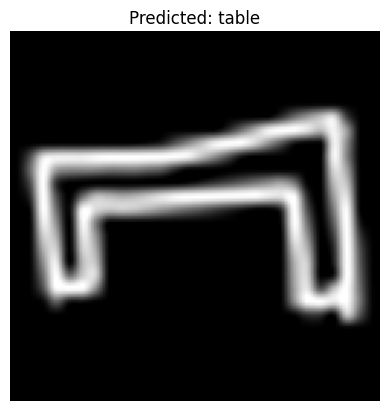

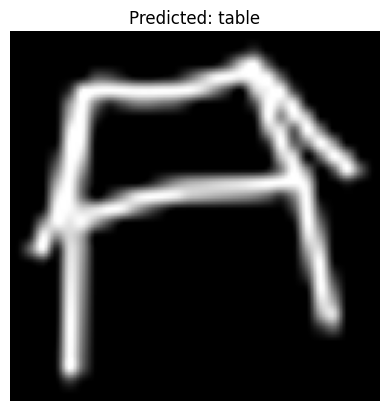

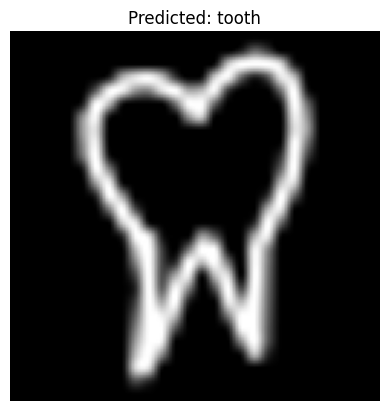

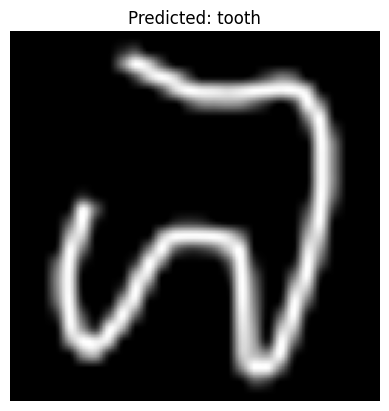

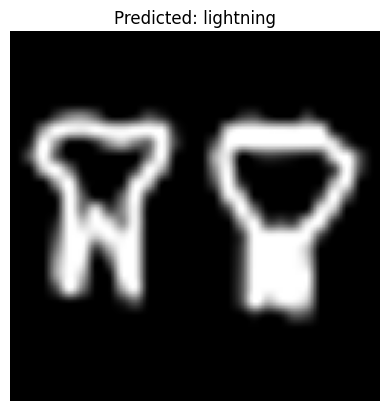

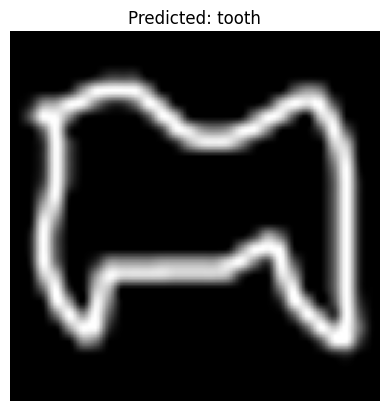

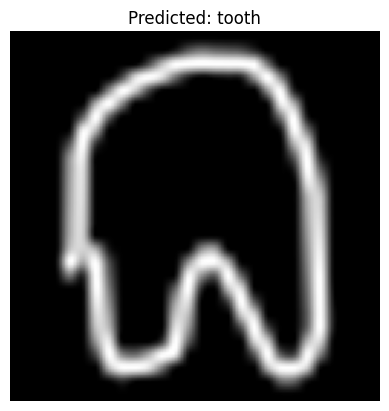

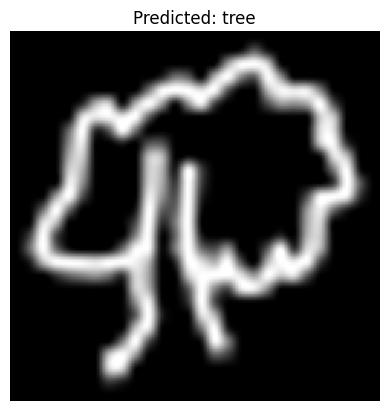

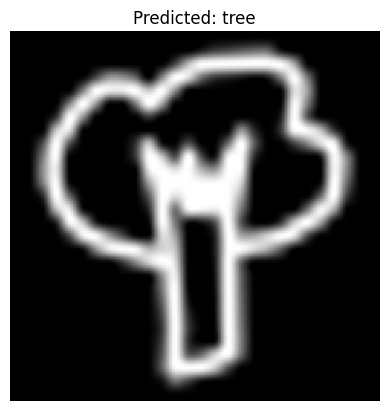

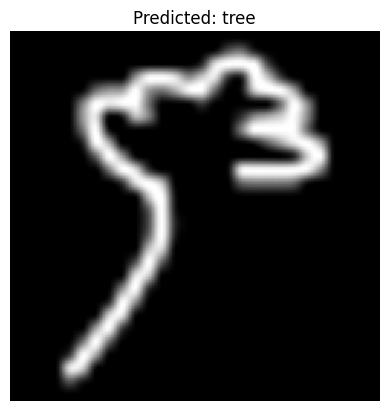

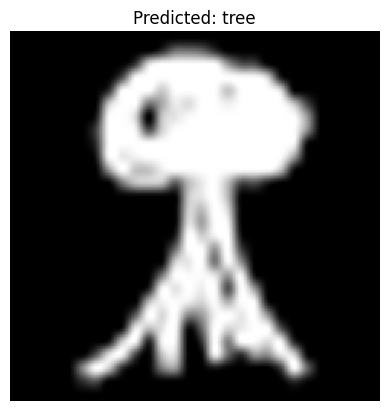

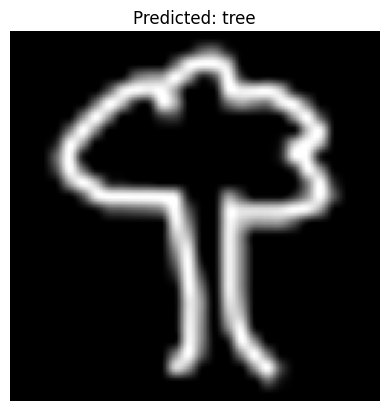

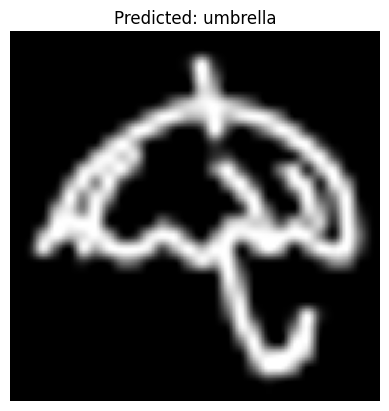

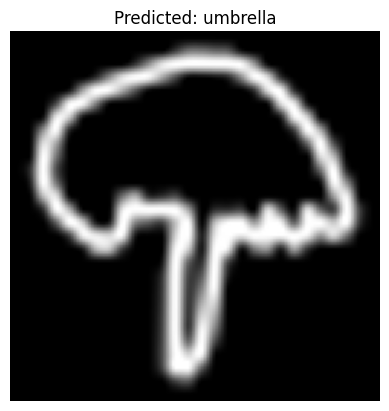

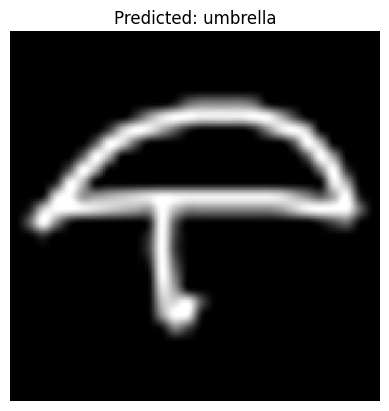

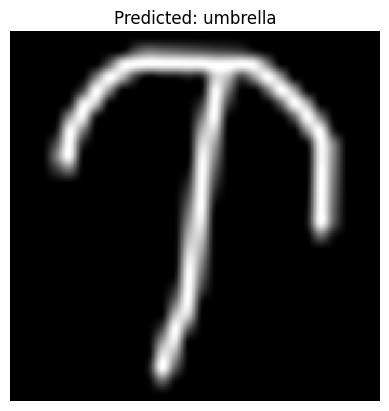

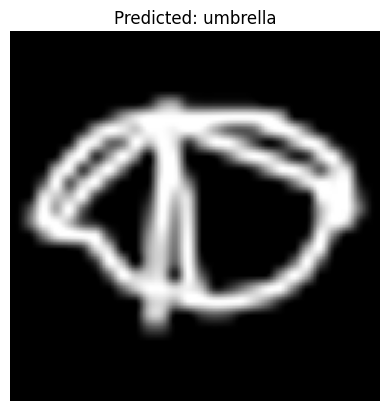

In [ ]:

#Show Predictions

predicted_labels = []

for i in range(len(inference_gen)):
    batch = inference_gen[i]
    preds = model.predict(batch, verbose=0)
    pred_idx = np.argmax(preds[0])
    pred_label = class_names[pred_idx]
    predicted_labels.append(pred_label)

    img = image.array_to_img(batch[0])
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}")
    plt.show()
